数据挖掘互评作业3： 分类、预测与聚类

* 所选任务：Video Game Sales 电子游戏销售分析
* 数据集地址：https://www.kaggle.com/gregorut/videogamesales
* Github地址：https://github.com/Xiemixue/DataMining_MutualEvaluationAssignment_3

# 数据预处理

## 数据集属性及含义

    Rank：总销售量的排名
    Name：游戏名称
    Platform：游戏发行平台
    Year：游戏发行时间
    Genre：游戏类别
    Publisher：发行商
    NA_Sales：北美的销售量，单位为百万
    EU_Sales：欧洲的销售量，单位为百万
    JP_Sales：日本的销售量，单位为百万
    Other_Sales：其它地区的销售量，单位为百万
    Global_Sales：全球的销售量

## 数据读取

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import warnings
import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings("ignore")

filename = 'vgsales.csv'
vgs = pd.read_csv(filename, index_col='Rank')

print("shape={}".format(vgs.shape))
vgs.head(5)    #打印前5行


shape=(16598, 10)


,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
Rank,,,,,,,,,,
1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37


## 缺失值统计及处理

In [2]:
vgs.isnull().sum()    #统计缺失值

Name              0
Platform          0
Year            271
Genre             0
Publisher        58
NA_Sales          0
EU_Sales          0
JP_Sales          0
Other_Sales       0
Global_Sales      0
dtype: int64

可以发现，只有Year和Publisher这两个特征存在缺失值，且缺失值个数分别为271和58。考虑到这两个特征不好填充，且相对总体而言，缺失规模很小，所以选择将缺失值全部删除。

In [3]:
vgs = vgs.dropna()    #丢弃含有缺失值的行
vgs.isnull().sum()    #重新统计缺失值

Name            0
Platform        0
Year            0
Genre           0
Publisher       0
NA_Sales        0
EU_Sales        0
JP_Sales        0
Other_Sales     0
Global_Sales    0
dtype: int64

## 数据类型查看及转换

In [4]:
vgs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16291 entries, 1 to 16600
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Name          16291 non-null  object 
 1   Platform      16291 non-null  object 
 2   Year          16291 non-null  float64
 3   Genre         16291 non-null  object 
 4   Publisher     16291 non-null  object 
 5   NA_Sales      16291 non-null  float64
 6   EU_Sales      16291 non-null  float64
 7   JP_Sales      16291 non-null  float64
 8   Other_Sales   16291 non-null  float64
 9   Global_Sales  16291 non-null  float64
dtypes: float64(6), object(4)
memory usage: 1.4+ MB


为了方便后续的分析、预测，现将Year转为数值型：

In [5]:
vgs.Year = vgs.Year.astype(int)

# 电子游戏市场分析

    ——每年最受欢迎的游戏类型、发布平台、发行商及其全球销售额

## 最受欢迎的游戏类型

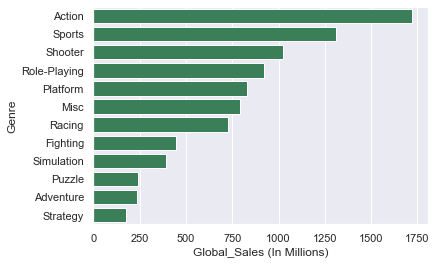

In [13]:
# 获取游戏类型的排序
Genre_data = vgs.groupby(['Genre']).sum().loc[:, 'Global_Sales'].sort_values(ascending = False)

# 进行画图
sns.barplot(y = Genre_data.index, x = Genre_data.values, orient='h', color="seagreen")
plt.ylabel("Genre")
plt.xlabel("Global_Sales (In Millions)")
plt.show()

从图中可以看到：动作类和运动类游戏最受欢迎

## 最受欢迎的游戏平台

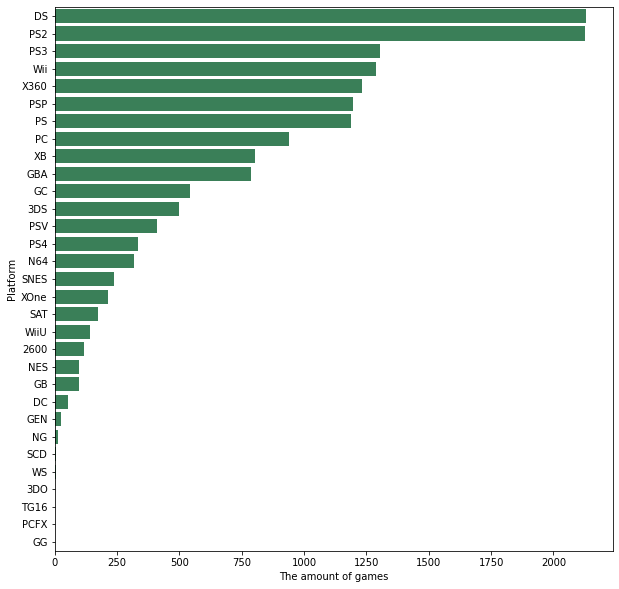

In [7]:
# 获取游戏平台的排序
Platform_data = vgs.groupby(['Platform']).count().loc[:,"Name"].sort_values(ascending = False)

# 进行画图
plt.figure(figsize=(10,10))
sns.barplot(y = Platform_data.index, x = Platform_data.values, orient='h', color="seagreen")
plt.ylabel("Platform")
plt.xlabel("The amount of games")
plt.show()

从图中可以看到：DS和PS2是最受欢迎的发行平台;而3DO、TG16、PCFX、GG等，已经在没落

## 最受欢迎的游戏发行商

游戏发行商个数=576


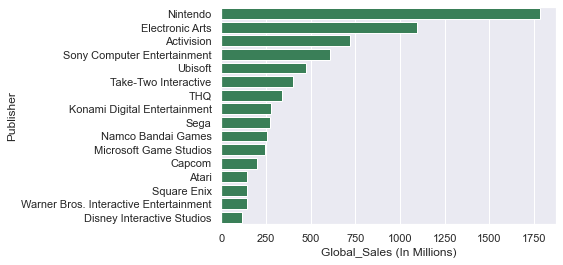

In [12]:
# 获取游戏发行商的排序
Publisher_data = vgs.groupby(['Publisher']).sum().loc[:,"Global_Sales"].sort_values(ascending = False)
print("游戏发行商个数={}".format(len(Publisher_data)))

# 只保留Publisher_data.values>50的数据
Publisher_data = Publisher_data[Publisher_data.values > 100]

# 进行画图
sns.set(font_scale=1)
plt.ylabel("Publisher")
plt.xlabel("Global_Sales (In Millions)")
sns.barplot(y = Publisher_data.index, x = Publisher_data.values, orient='h', color="seagreen")
plt.show()

由于游戏发行商的数量太多，无法在一张图片中显示出。因此只考虑Publisher_data.values>50，即销售量超过5000万份游戏发行商。

从图中可以看到：Nintendo最受欢迎的发行商，其销量远远超出了第二名Electronic Arts.

## 各地区及全球销售额分析

* 每年销售总额变化趋势

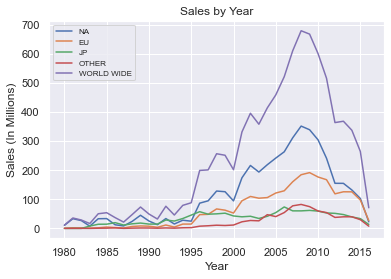

<Figure size 432x288 with 0 Axes>

In [18]:
def lineplot(df, ylabel, title='Sales by Year', legendsize = 10, legendloc = 'upper left'):
    year = df.index.values
    na = df.NA_Sales
    eu = df.EU_Sales
    jp = df.JP_Sales
    other = df.Other_Sales
    global_ = df.Global_Sales
    
    if df is count_sales_group:
        region_list = [na, eu, jp, other, global_]
        columns = ['NA', 'EU', 'JP', 'OTHER', 'WORLD WIDE']
    else:
        region_list = [na, eu, jp, other, global_]
        columns = ['NA', 'EU', 'JP', 'OTHER', 'WORLD WIDE']

    for i, region in enumerate(region_list):
        plt.plot(year, region, label = columns[i])

    plt.ylabel(ylabel)
    plt.xlabel('Year')
    plt.title(title)
    plt.legend(loc=legendloc, prop = {'size':legendsize})
    plt.show()
    plt.clf()

years = [2017, 2020]
total_sales_group = vgs.groupby(['Year']).sum().drop(years)
average_sales_group = vgs.groupby(['Year']).mean().drop(years)
count_sales_group = vgs.groupby(['Year']).count().drop(years)

lineplot(total_sales_group, title = 'Sales by Year', ylabel="Sales (In Millions)", legendsize = 8)


从图中可以看到，全球游戏销售额一直在持续增长，在2008年有一个高峰期。众所周知，2008年全球金融危机，经济衰退对电子游戏行业也造成了一定的影响。

* 每年销售额平均值变化趋势

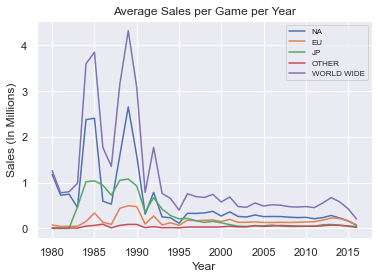

<Figure size 432x288 with 0 Axes>

In [14]:
lineplot(average_sales_group, title = 'Average Sales per Game per Year', ylabel ='Sales (In Millions)', 
         legendsize = 8, legendloc = 'upper right')

In [ ]:
从图中可以看出，1988年左右开始，游戏的平均销售额大幅下降。

* 每年发行游戏数量的变换趋势

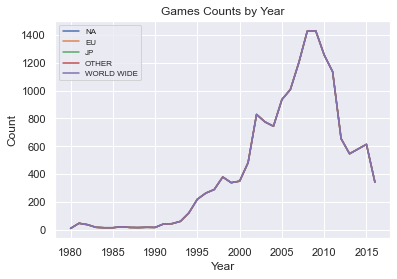

<Figure size 432x288 with 0 Axes>

In [19]:
lineplot(count_sales_group, title = 'Games Counts by Year', ylabel ='Count', 
         legendsize = 8, legendloc = 'upper left')

综合这三个折线图，可以看出，在90年代后期及以后，电子游戏行业的发展是非常繁荣的。虽然游戏平均销售额减少了，但是发布的游戏数量大幅提高，所以总的销售额也在增长。但到了2008年，全球金融危机，对电子游戏市场造成了严重的影响，游戏发布数量减少，总销售额大幅下降。

## 词云

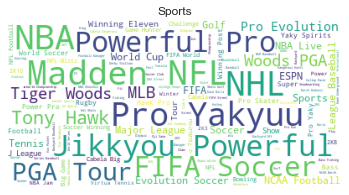

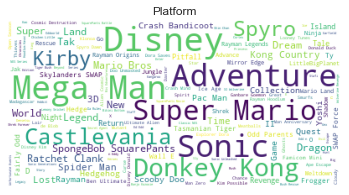

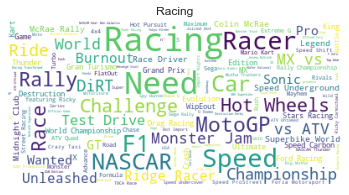

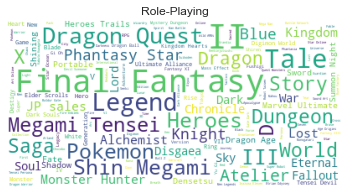

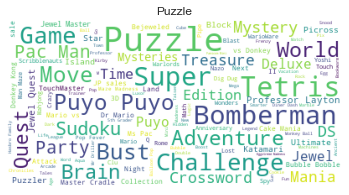

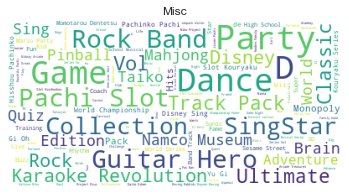

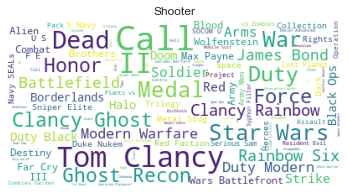

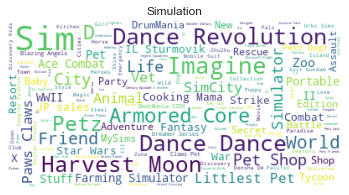

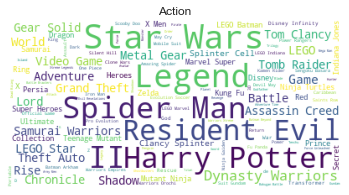

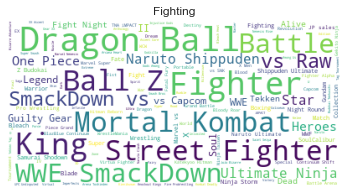

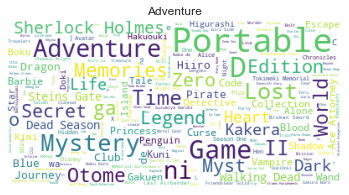

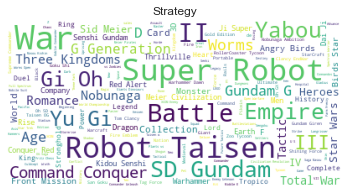

In [23]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

stopwords = set(STOPWORDS)

for x in vgs.Genre.unique():
    wc = WordCloud(background_color="white", max_words=2000, 
                   stopwords=stopwords, max_font_size=40, random_state=42)
    wc.generate(vgs.Name[vgs.Genre == x].to_string())
    plt.imshow(wc)
    plt.title(x)
    plt.axis("off")
    plt.show()

看看在各个类型的游戏的命名中，哪些词语出现频率较高。以Sports类游戏为例子，命名中出现较多的词有：NBA、FIFA、Soccer等与运动有关的词语。

# 预测销售额

数据集中每年的销售额如下：

In [42]:
# 获取销售额数据
sales = vgs[['Year', 'Global_Sales']].dropna()
sales = sales.groupby(by = ['Year']).sum().reset_index()
print(sales)

    Year  Global_Sales
0   1980         11.38
1   1981         35.77
2   1982         28.86
3   1983         16.79
4   1984         50.36
5   1985         53.94
6   1986         37.07
7   1987         21.74
8   1988         47.22
9   1989         73.45
10  1990         49.39
11  1991         32.23
12  1992         76.16
13  1993         45.98
14  1994         79.17
15  1995         88.11
16  1996        199.15
17  1997        200.98
18  1998        256.47
19  1999        251.27
20  2000        201.56
21  2001        331.47
22  2002        395.52
23  2003        357.85
24  2004        414.01
25  2005        458.51
26  2006        521.04
27  2007        609.92
28  2008        678.90
29  2009        667.30
30  2010        600.29
31  2011        515.80
32  2012        363.49
33  2013        368.11
34  2014        337.03
35  2015        264.44
36  2016         70.90
37  2017          0.05
38  2020          0.29


## 划分数据集

In [49]:
from sklearn.preprocessing import LabelEncoder
# categorical_labels = ['Platform','Genre','Publisher','NA_Sales','EU_Sales','JP_Sales']
categorical_labels = ['Platform','Genre','Publisher']
numerical_lables = ['Global_Sales']
enc = LabelEncoder()
encoded_df = pd.DataFrame(columns=['Platform','Genre','Publisher','Global_Sales'])

for label in categorical_labels:
    temp_column = vgs[label]
    encoded_temp_col = enc.fit_transform(temp_column)
    encoded_df[label] = encoded_temp_col

for label in numerical_lables:
    encoded_df[label] = vgs[label].values
    
print(encoded_df.head())

   Platform  Genre  Publisher  Global_Sales
0        26     10        359         82.74
1        11      4        359         40.24
2        26      6        359         35.82
3        26     10        359         33.00
4         5      7        359         31.37


In [52]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(encoded_df, test_size=0.1, random_state=1)

def data_splitting(df):
    x=df.drop(['Global_Sales'], axis=1)
    y=df['Global_Sales']
    return x, y

x_train, y_train = data_splitting(train)
x_test, y_test = data_splitting(test)

### Linear Regression

使用Linear Regression预测模型:

In [51]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score,mean_squared_error
log = LinearRegression()
log.fit(x_train , y_train)
y_pred = log.predict(x_test)
n = len(x_test)
p = x_test.shape[1]
r2_value = r2_score(y_test, y_pred)
adjusted_r2_score = 1 - (((1-r2_value)*(n-1)) /(n-p-1))
print("r2_score for Linear Reg model : ",r2_score(y_test,y_pred))
print("adjusted_r2_score Value       : ",adjusted_r2_score)                         
print("MSE for Linear Regression     : ",mean_squared_error(y_test,y_pred))

r2_score for Linear Reg model :  -0.0006404221007900723
adjusted_r2_score Value       :  -0.0024866221415664747
MSE for Linear Regression     :  2.895277971549873


### Random Forest

使用Random Forest预测模型:

In [53]:
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=200,min_samples_split=20,random_state=43)
rf_model.fit(x_train,y_train)
y_pred = rf_model.predict(x_test)
n = len(x_test)
p = x_test.shape[1]
r2_value = r2_score(y_test,y_pred)
adjusted_r2_score = 1 - (((1-r2_value)*(n-1)) /(n-p-1))
print("r2_score for Random Forest Reg model : ",r2_score(y_test,y_pred))
print("adjusted_r2_score Value              : ",adjusted_r2_score)
print("MSE for Random Forest Regression     : ",mean_squared_error(y_test,y_pred))

r2_score for Random Forest Reg model :  0.13590411898436794
adjusted_r2_score Value              :  0.1343098461411657
MSE for Random Forest Regression     :  2.50019658845997


和线性回归对比，随机森林效果更好。